In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as pth_transforms
from PIL import Image
import matplotlib.pyplot as plt
import vision_transformer as vits

In [2]:
# DINO ATTENTION MAPS

if __name__ == '__main__':

    image_size = (480, 480)  
    patch_size = 16  
    output_dir = '.'

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vits.vit_base(
        patch_size=patch_size,
        num_classes=0 
    )

    pretrained_weights = 'dino_vitbase16_pretrain.pth' 
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    state_dict = {k.replace("module.", "").replace("backbone.", ""): v for k, v in state_dict.items()}  
    model.load_state_dict(state_dict, strict=False) 

    for p in model.parameters():
        p.requires_grad = False  
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG').convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),

    ])
    img = transform(img)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))  

    nh = attentions.shape[1] 
    attentions = attentions[0, :, 0, :]
    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


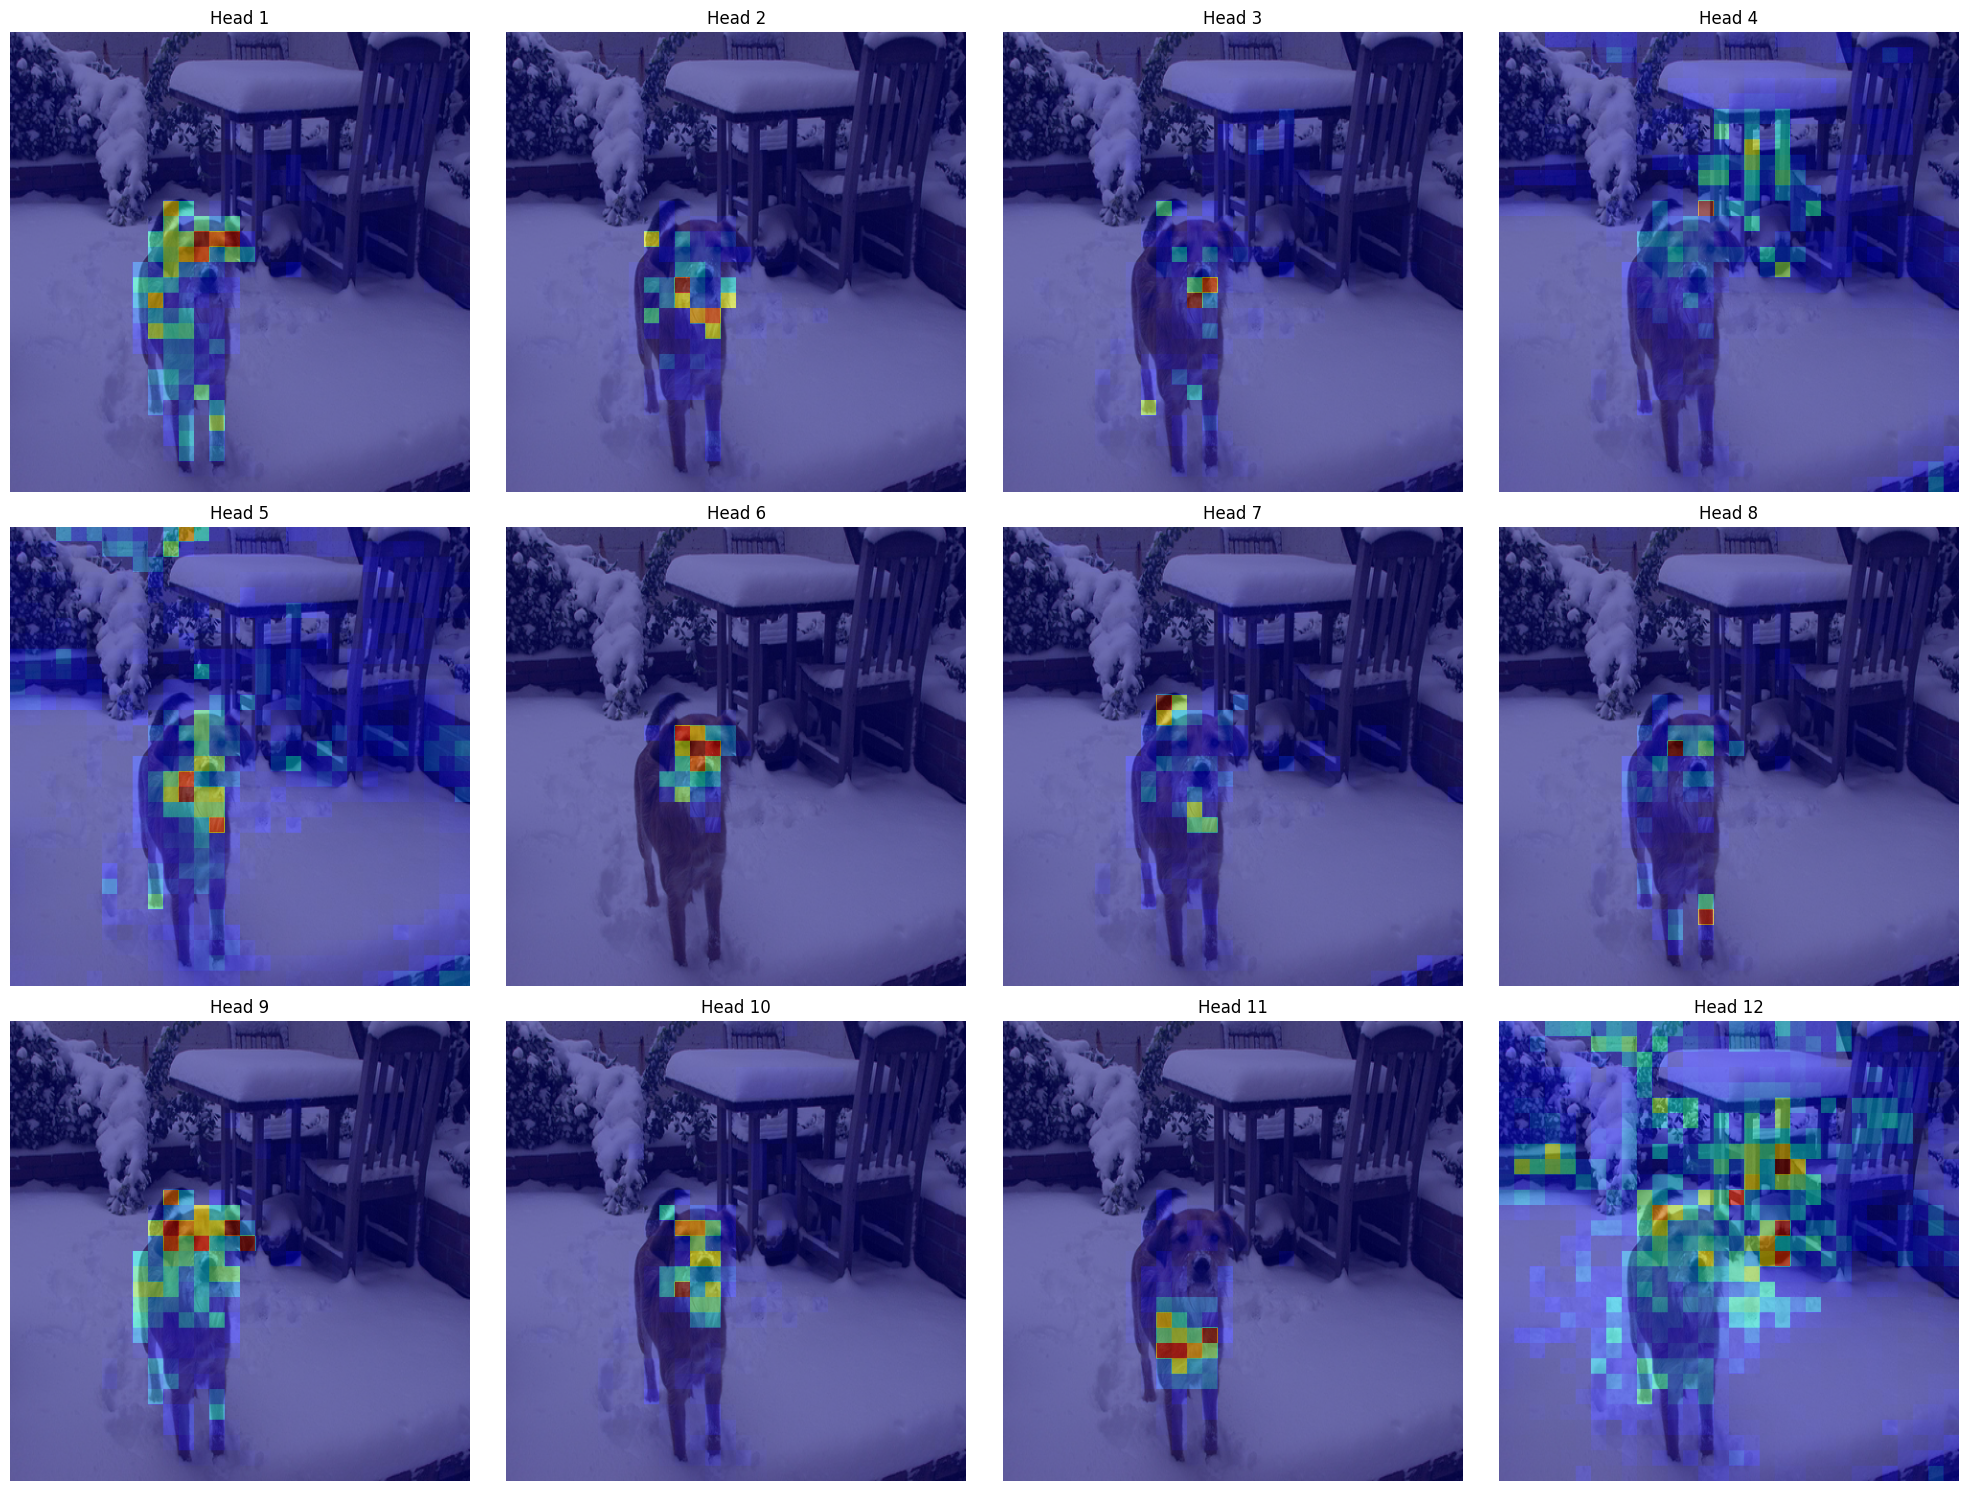

In [3]:
heads_per_row = 4  
num_rows = 3
fig, axs = plt.subplots(num_rows, heads_per_row, figsize=(heads_per_row * 5, num_rows * 5))
axs = axs.reshape(num_rows, heads_per_row) if num_rows > 1 else [axs]

for i, attn in enumerate(attentions):
    row = i // heads_per_row
    col = i % heads_per_row
    axs[row][col].imshow(img[0].permute(1, 2, 0).cpu().numpy())  
    axs[row][col].imshow(attn, cmap="jet", alpha=0.5)  
    axs[row][col].axis("off")
    axs[row][col].set_title(f"Head {i + 1}")

for i in range(len(attentions), num_rows * heads_per_row):
    row = i // heads_per_row
    col = i % heads_per_row
    axs[row][col].axis("off")

plt.tight_layout()
plt.show()

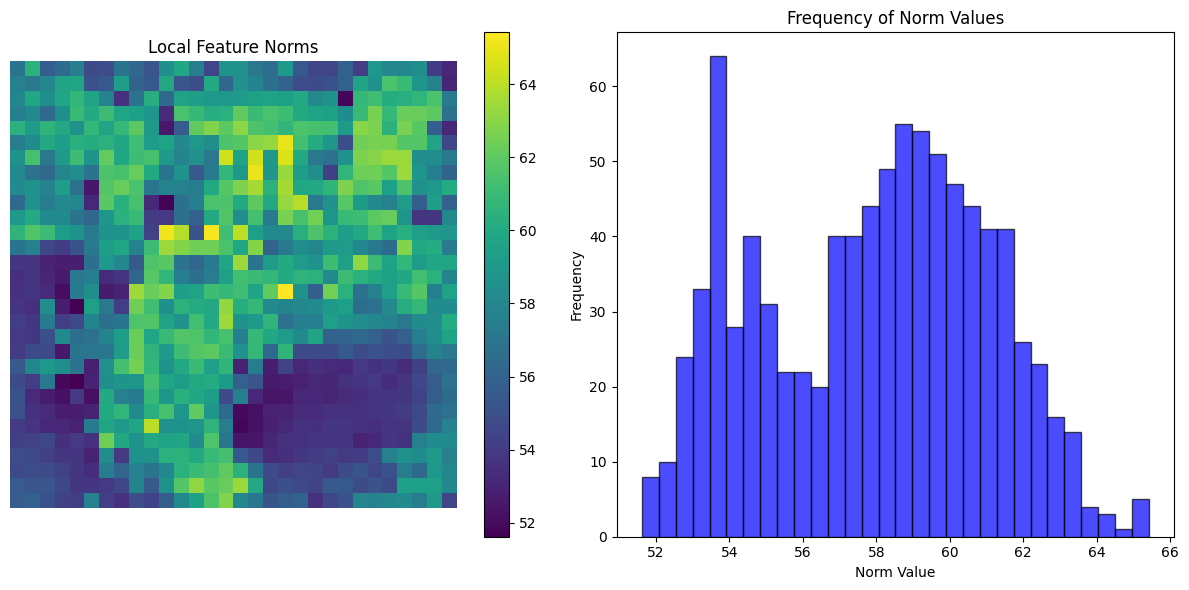

In [4]:
# DINO NORMS 

with torch.no_grad():

    intermediate_features = model.get_intermediate_layers(img.to(device), n=1) 
    patch_features = intermediate_features[-1][:, 1:, :] 

    local_feature_norms = torch.norm(patch_features, dim=-1)

    w_featmap = h_featmap = img.shape[-1] // 16
    local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)
    flattened_norms = local_feature_norms[0].cpu().numpy().flatten()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title("Local Feature Norms")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
    plt.title("Frequency of Norm Values")
    plt.xlabel("Norm Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()
